In [2]:
import tensorflow as tf

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import sklearn.linear_model as lm
logreg = lm.LogisticRegression(multi_class='multinomial', solver='lbfgs')
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from numpy import dstack

import os
from functools import partial
from collections import namedtuple
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.9.1


In [2]:
pip install tensorflow

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*')))
print(image_count_test)

14700
300


In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14700 files belonging to 3 classes.
Using 11760 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 3 classes.
Using 60 files for validation.


In [10]:
# List out all the classes of cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['lung_aca', 'lung_n', 'lung_scc']


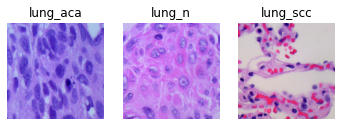

In [33]:
import matplotlib.pyplot as plt

### visualize training or validation data to 
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(10):
  for i in range(3):
    ax = plt.subplot(3,5, i+1)
    plt.imshow(images[i].numpy().astype("int64"))
    plt.title(class_names[i])
    plt.axis("off")

In [13]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:

image_size = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255)
  #layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
])

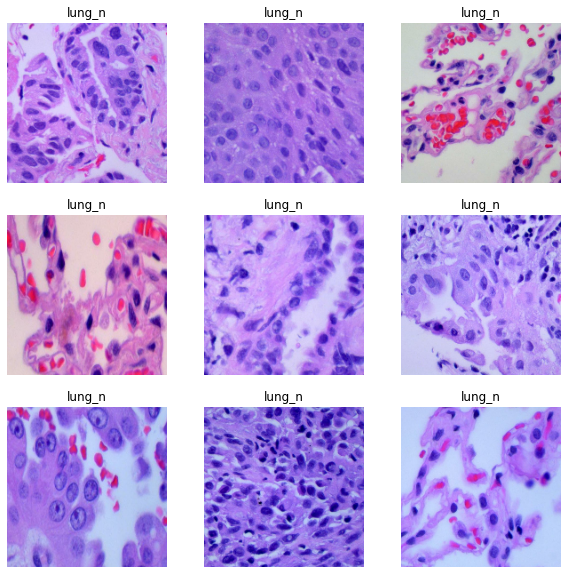

In [16]:
train_ds.take(1)
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    
    plt.imshow(resize_and_rescale(images[i].numpy().astype("int64")))
    plt.title(class_names[1])
    plt.axis("off")

In [17]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
368/368 [==============================] - 213s 554ms/step - loss: 8.4924 - accuracy: 0.7183 - val_loss: 0.3633 - val_accuracy: 0.7833
Epoch 2/5
368/368 [==============================] - 202s 549ms/step - loss: 0.3982 - accuracy: 0.8168 - val_loss: 0.3371 - val_accuracy: 0.8000
Epoch 3/5
368/368 [==============================] - 201s 547ms/step - loss: 0.3563 - accuracy: 0.8420 - val_loss: 0.3773 - val_accuracy: 0.7833
Epoch 4/5
368/368 [==============================] - 201s 547ms/step - loss: 0.3012 - accuracy: 0.8694 - val_loss: 0.2053 - val_accuracy: 0.9000
Epoch 5/5
368/368 [==============================] - 204s 554ms/step - loss: 0.2351 - accuracy: 0.9027 - val_loss: 0.3109 - val_accuracy: 0.8500


In [20]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

2/2 [==============================] - 0s 160ms/step - loss: 0.3109 - accuracy: 0.8500
Accuracy 0.8500000238418579


In [21]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)      

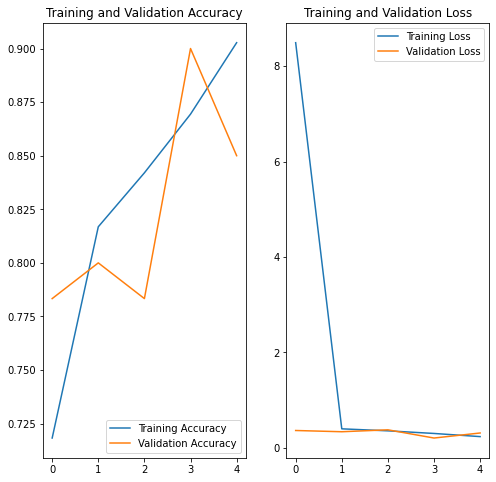

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()